In [ ]:
# @title
import warnings
warnings.filterwarnings('ignore')


try:
    import cirq
except ImportError:
    print('installing cirq...')
    !pip install cirq --quiet
    import cirq
    print('installed cirq.')


#!git clone https://github.com/the-codingschool/bb84.git
#from bb84.bb84 import BB84
from cirq import NamedQubit, Simulator, Circuit

class BB84:

    """
    Implements the BB84 protocol for quantum key distribution.

    The BB84 protocol allows two parties, Alice and Bob, to generate a shared secret key, which can then be used
    for secure communication. The protocol also involves checking for the presence of an eavesdropper, Eve.
    This implementation provides a simulated environment for the protocol's execution, including the potential
    interception by Eve.


    <b>NOTE</b>:
        This class requires external definitions for the quantum circuits and simulator to function properly.

    <br>

    © 2024 The Coding School, All rights reserved.
    """

    qubit: NamedQubit
    """The qubit being used for the protocol. Must be defined externally, for example:
    ```python
    protocol.qubit = cirq.NamedQubit('q0')
    ```
    """

    simulator: Simulator
    """The quantum circuit simulator. Must be defined externally, for example:
    ```python
    protocol.simulator = cirq.Simulator()
    ```
    """

    alice_send_0_no_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 0 without an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_0_no_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_1_no_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 1 without an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_1_no_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_0_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 0 with an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_0_H_circuit = cirq.Circuit()
    ```
    """

    alice_send_1_H_circuit: Circuit
    """The quantum circuit that Alice will use to encode a 1 with an H gate. Must be defined externally, for example:
    ```python
    protocol.alice_send_1_H_circuit = cirq.Circuit()
    ```
    """

    eve_intercept_circuit: Circuit
    """The quantum circuit that Eve will use to intercept the qubit between Phase 1 and 2. Must be defined externally, for example:
    ```python
    protocol.eve_intercept_circuit = cirq.Circuit()
    ```
    """

    bob_receive_no_H_circuit: Circuit
    """The quantum circuit that Bob will use to receive and measure the qubit during Phase 3 without using an H gate. Must be defined externally, for example:
    ```python
    protocol.bob_receive_no_H_circuit = cirq.Circuit()
    ```
    """

    bob_receive_H_circuit: Circuit
    """The quantum circuit that Bob will use to receive and measure the qubit during Phase 3 using an H gate. Must be defined externally, for example:
    ```python
    protocol.bob_receive_H_circuit = cirq.Circuit()
    ```
    """


    eve_intercept: str
    """Indicates if Eve intercepts the qubits ('yes' or 'no'). Should be set upon initialization or after calling `reset()`."""

    alice_bit: int
    """The current bit Alice wants to send. Should only be modified indirectly through the `send_bit` method's parameters."""

    bob_bit: int
    """The bit received by Bob after measurement. Should only be modified indirectly through the `send_bit` method's parameters."""

    eve_bit: int
    """The bit measured by Eve if interception occurs. Should only be modified indirectly through the `send_bit` method's parameters."""

    does_alice_apply_H: str
    """Indicates if Alice applies the Hadamard gate ('yes' or 'no'). Should only be modified indirectly through the `send_bit` method's parameters."""

    does_bob_apply_H: str
    """Indicates if Bob applies the Hadamard gate ('yes' or 'no'). Should only be modified indirectly through the `send_bit` method's parameters."""


    alice_key: list
    """The secret key generated by Alice. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    bob_key: list
    """The secret key generated by Bob. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    eve_key: list
    """The key intercepted by Eve, if any. <b>SHOULD NOT BE MODIFIED BY USER</b>."""

    bit_num: int
    """Counter for the number of bits processed so far. <b>SHOULD NOT BE MODIFIED BY USER</b>."""


    def __init__(self, eve_intercept = 'no'):

      """
      Initializes the BB84 protocol simulation with default or specified settings.

      Parameters:
          `eve_intercept` (str, optional): Determines if Eve will attempt to intercept the qubits ('yes' or 'no').
                                         Defaults to 'no'.

      Example Usage:
      ```python
      protocol_without_eve = BB84()

      also_protocol_without_eve = BB84(eve_intercept = 'no')

      protocol_with_eve = BB84(eve_intercept = 'yes')
      ```
      """

      self.alice_bit = None
      self.bob_bit = None

      self.eve_bit = None
      self.eve_intercept = eve_intercept

      self.does_alice_apply_H = None
      self.does_bob_apply_H = None

      self.qubit = None
      self.simulator = None

      self.alice_send_0_no_H_circuit = None
      self.alice_send_1_no_H_circuit = None
      self.alice_send_0_H_circuit = None
      self.alice_send_1_H_circuit = None

      self.eve_intercept_circuit = None

      self.bob_receive_no_H_circuit = None
      self.bob_receive_H_circuit = None

      self.alice_key = []
      self.bob_key = []
      self.eve_key = []

      self.bit_num = 1


    def phase_1_circuit(self):

      """
      Creates a circuit such that Alice encodes her bit into a qubit and applies an H gate if she's chosen to do so.
      Then she sends this qubit through her quantum channel to Bob, hoping Eve does not intercept.

      <b>Returns</b>:
          The quantum circuit for Phase 1 of BB84 (through Alice sending her qubit).

      <b>INTERNAL USE ONLY</b>
      """

      if self.alice_bit == 0:
        if self.does_alice_apply_H == 'no':
          return self.alice_send_0_no_H_circuit
        else:
          return self.alice_send_0_H_circuit

      else:
        if self.does_alice_apply_H == 'no':
          return self.alice_send_1_no_H_circuit
        else:
          return self.alice_send_1_H_circuit


    def eve_circuit(self):

      """
      Creates a circuit for Eve's role in the protocol, which depends on if she's intercepting or not.

      <b>Returns</b>:
          The quantum circuit for Eve's interception if it occurs, otherwise an empty circuit.

      <b>INTERNAL USE ONLY</b>
      """

      if self.eve_intercept == 'yes':
        return self.eve_intercept_circuit
      else:
        return cirq.Circuit()


    def phase_2_circuit(self):

      """
      Creates a circuit such that Bob receives the qubit, applies an H gate if he's decided to do so,
      and then measures it.

      <b>Returns</b>:
          The quantum circuit for Phase 2 of BB84 (through Bob measuring the qubit).

      <b>INTERNAL USE ONLY</b>
      """

      if self.does_bob_apply_H == 'no':
        return self.bob_receive_no_H_circuit
      else:
        return self.bob_receive_H_circuit


    def restart(self):

      """
      Resets the protocol such that the circuits are all the same, but they are being used with blank keys and on a new quantum channel.
      """

      self.alice_key = []
      self.bob_key = []
      self.eve_key = []

      self.bit_num = 1


    def send_bit(self, alice_bit, does_alice_apply_H, does_bob_apply_H, compare_bits = 'no'):

      """
      Simulates the full BB84 protocol, potentially intercepted by Eve.

      Parameters:
        <ul>
          <li>`alice_bit` (int): The bit Alice wants to send.</li>
          <li>`does_alice_apply_H` (str): Indicates if Alice applies the Hadamard gate ('yes' or 'no').</li>
          <li>`does_bob_apply_H` (str): Indicates if Bob applies the Hadamard gate ('yes' or 'no').</li>
          <li>`compare_bit` (str, optional): Determines if Alice and Bob compare their bits directly ('yes' or 'no').
                                       Defaults to 'no'.</li>
        </ul>

      <b>NOTE</b>:
          This method simulates the entire process of sending a bit, including preparation, potential interception,
          and measurement. It also handles error checking for uninitialized objects that are required in the given case.


      Example Usage:
      ```python
      # Alice sends a 1 without an H gate and Bob receives and measures the qubit without an H gate.
      # The default is that they will not compare their bits and instead will add them to their key
      # if they both made the same choice of H gate or not.
      protocol.send_bit(alice_bit = 1, does_alice_apply_H = 'no', does_bob_apply_H = 'no')


      # Same as above, except Alice and Bob will compare bits instead of adding them to their key.
      protocol.send_bit(alice_bit = 1, does_alice_apply_H = 'no', does_bob_apply_H = 'no', compare_bits = 'yes')
      ```
      """

      self.alice_bit = alice_bit
      self.does_alice_apply_H = does_alice_apply_H
      self.does_bob_apply_H = does_bob_apply_H

      if self.qubit == None:
        print('Error: A qubit object must be defined first.')
        return

      elif self.simulator == None:
        print('Error: A simulator object must be defined first.')
        return


      # Prepare Alice's qubit
      alice_circuit = self.phase_1_circuit()

      if alice_circuit == None:

        applies_H = 'no H'
        if self.does_alice_apply_H == 'yes':
          applies_H = 'an H'

        print('Error: Alice\'s circuit for sending a', self.alice_bit, 'with', applies_H, 'must be defined first.')
        return


      # Eve's interception
      eve_circuit = self.eve_circuit()

      if eve_circuit == None:

        print('Error: Eve\'s interception circuit must be defined first.')
        return

      # Bob's measurement
      bob_circuit = self.phase_2_circuit()

      if bob_circuit == None:

        applies_H = 'no H'
        if self.does_bob_apply_H == 'yes':
          applies_H = 'an H'

        print('Error: Bob\'s circuit for measuring with', applies_H, 'must be defined first.')
        return

      # Combine circuits and run simulation
      bb84_circuit = alice_circuit + eve_circuit + bob_circuit
      results = self.simulator.run(bb84_circuit)
      self.bob_bit = results.measurements['q0'][0][0]

      if self.eve_intercept:
        self.eve_bit = results.measurements.get('eve', [[None]])[0][0]

      # Print results
      print('\033[43m\033[1mATTEMPTED BIT', self.bit_num, '\033[0m\033[0m')

      print('\n\033[32m\033[1mPHASE 1: SENDING\033[0m\033[0m\033[0m')
      print('\033[47m\033[1mAlice (to herself)\033[0m\033[0m: I sent a', self.alice_bit, 'and', 'did not use' if self.does_alice_apply_H == 'no' else 'used', 'an H')

      if self.eve_intercept == 'yes':
        print('EVE INTERCEPTS!')
        print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: I measured a', self.eve_bit, 'and will now send the qubit to Bob')

      print('\n\033[32m\033[1mPHASE 2: RECEIVING\033[0m\033[0m')
      print('\033[47m\033[1mBob (to himself)\033[0m\033[0m: I', 'did not use' if self.does_bob_apply_H == 'no' else 'used', 'an H and measured a', self.bob_bit)

      print('\n\033[32m\033[1mPHASE 3: COMPARING\033[0m\033[0m')
      print('Alice and Bob are comparing choice of H\'s', 'and the bits themselves.' if compare_bits == 'yes' else 'but not the bits themselves.', '\n')
      print('\033[47m\033[1mAlice\033[0m\033[0m: I', 'did not use' if self.does_alice_apply_H == 'no' else 'used', 'an H')
      print('\033[47m\033[1mBob\033[0m\033[0m: I', 'did not use' if self.does_bob_apply_H == 'no' else 'used', 'an H')

      print('')
      if compare_bits == 'yes':
        print('\033[47m\033[1mAlice\033[0m\033[0m: I sent a', self.alice_bit)
        print('\033[47m\033[1mBob\033[0m\033[0m: I measured a', self.bob_bit, '\n')

        if self.does_alice_apply_H == self.does_bob_apply_H:
          if self.alice_bit == self.bob_bit:
            print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: Our bits match, so it doesn\'t seem like Eve is intercepting.')

            if self.eve_intercept == 'yes':
              print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: Mwuhaha, I\'ve gone undetected.')

          else:
            print('\033[91m\033[1mAlice and Bob: Our bits are different, so Eve must have intercepted! Let\'s start over with new keys and a new quantum channel!\033[0m\033[0m')
            self.restart()

        else:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: We made different choices, we should not use this bit.')

      else:
        if self.does_alice_apply_H == self.does_bob_apply_H:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: Great, let\'s add this bit to our keys.')
          self.alice_key += [self.alice_bit]
          self.bob_key += [self.bob_bit]

          if self.eve_intercept:
            self.eve_key += [self.eve_bit]
        else:
          print('\033[47m\033[1mAlice and Bob\033[0m\033[0m: We made different choices, we should not use this bit.')

      print('')
      print('\033[47m\033[1mAlice (to herself)\033[0m\033[0m: My key is now', self.alice_key)
      print('\033[47m\033[1mBob (to himself)\033[0m\033[0m: My key is now', self.bob_key)

      if self.eve_intercept == 'yes':
        print('\033[47m\033[1mEve (to herself)\033[0m\033[0m: My key is now:', self.eve_key)


      print('\nThe circuit used this round:', bb84_circuit)

      self.bit_num += 1
      print('='*75, end='\n\n')

import matplotlib.pyplot as plt

installing cirq...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.8 MB/s eta 0:00:0

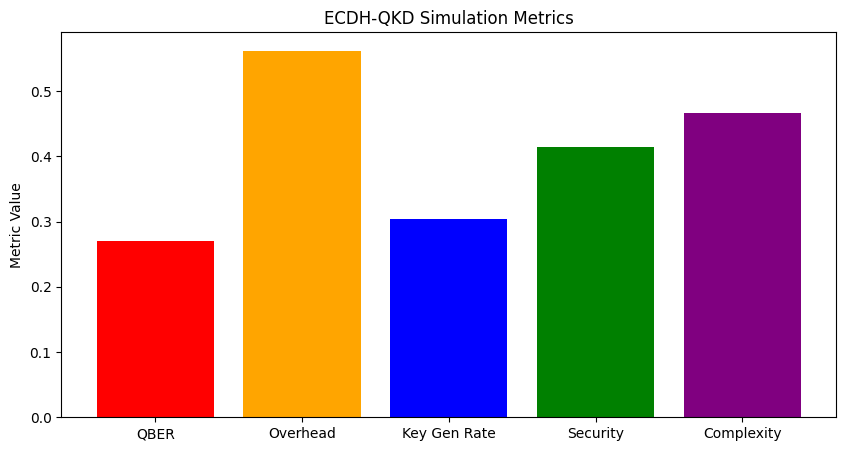

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.10 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.27
Overhead: 0.56
Key Gen Rate: 0.30
Security: 0.41
Complexity: 0.47


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("ECDH-QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


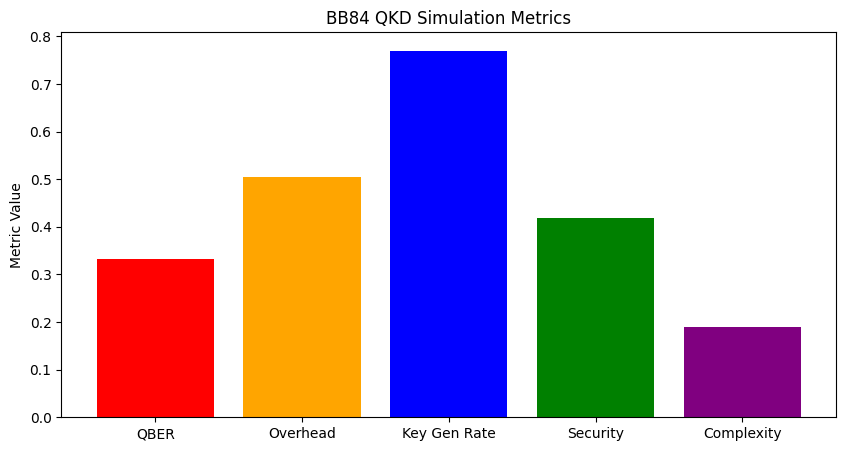

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.73 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.33
Overhead: 0.50
Key Gen Rate: 0.77
Security: 0.42
Complexity: 0.19


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("BB84 QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


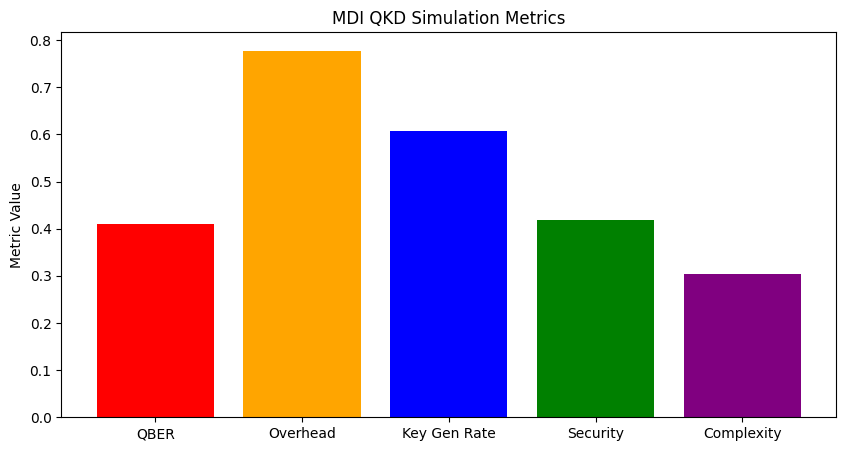

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.37 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.41
Overhead: 0.78
Key Gen Rate: 0.61
Security: 0.42
Complexity: 0.30


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("MDI QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


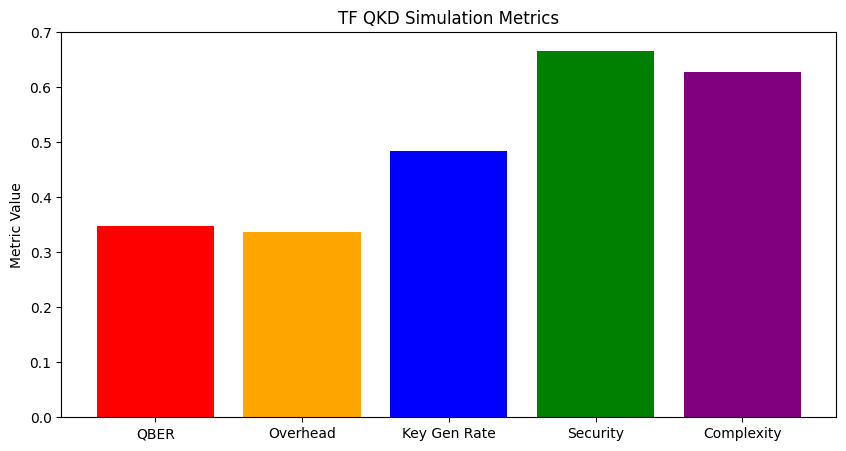

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.49 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.35
Overhead: 0.34
Key Gen Rate: 0.48
Security: 0.67
Complexity: 0.63


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("TF QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


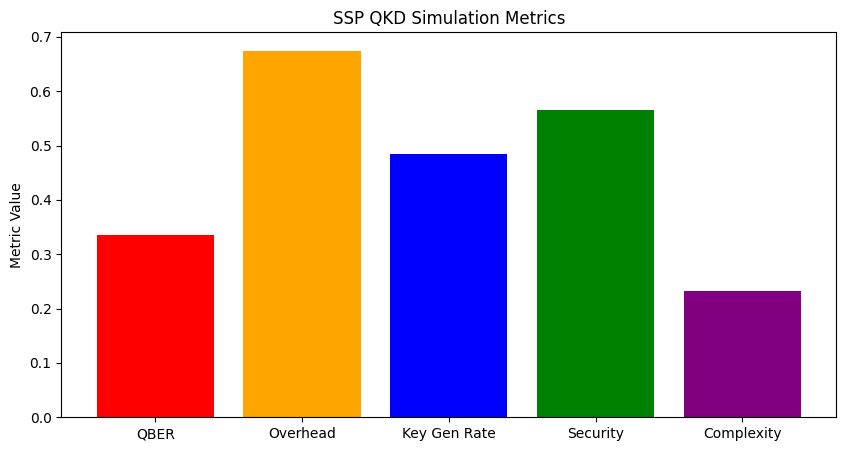

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.46 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.34
Overhead: 0.67
Key Gen Rate: 0.48
Security: 0.57
Complexity: 0.23


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("SSP QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


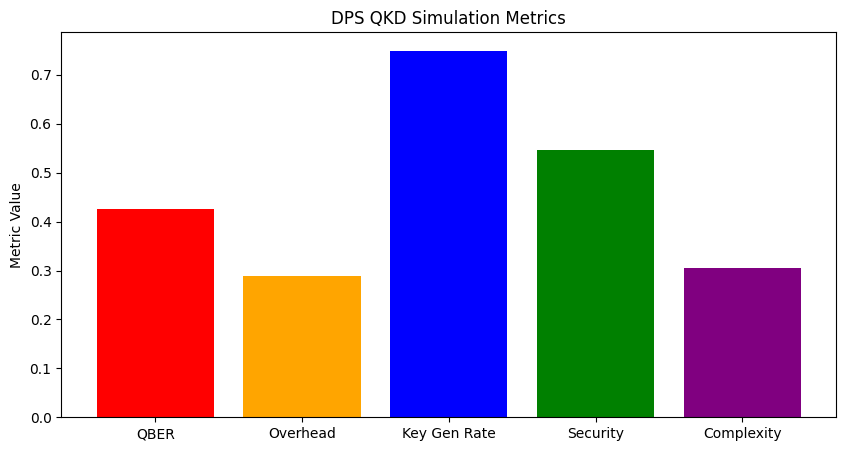

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.66 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.43
Overhead: 0.29
Key Gen Rate: 0.75
Security: 0.55
Complexity: 0.31


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("DPS QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


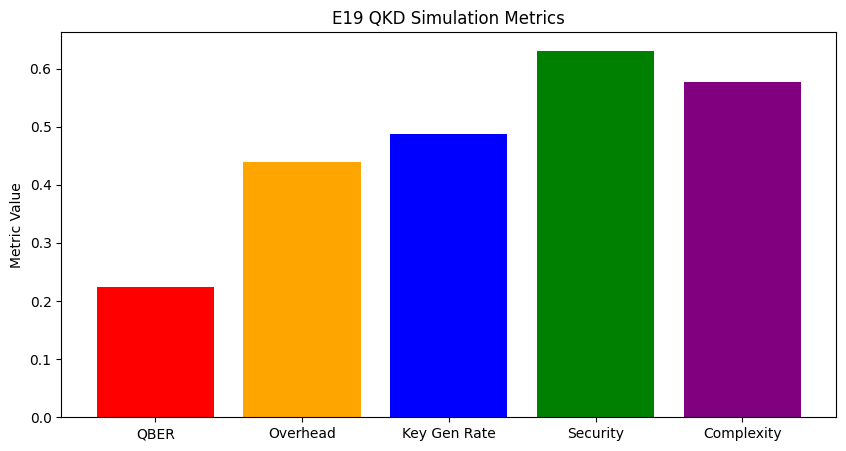

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.77 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.22
Overhead: 0.44
Key Gen Rate: 0.49
Security: 0.63
Complexity: 0.58


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("E19 QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


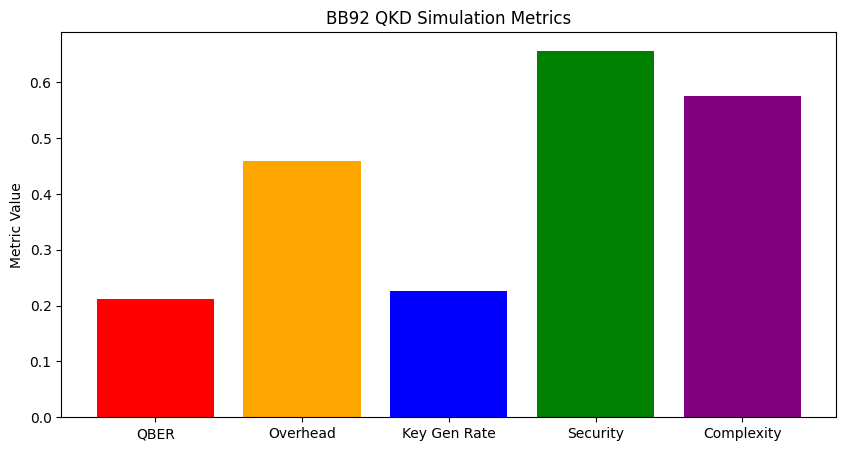

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.26 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.21
Overhead: 0.46
Key Gen Rate: 0.23
Security: 0.66
Complexity: 0.57


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("BB92 QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()


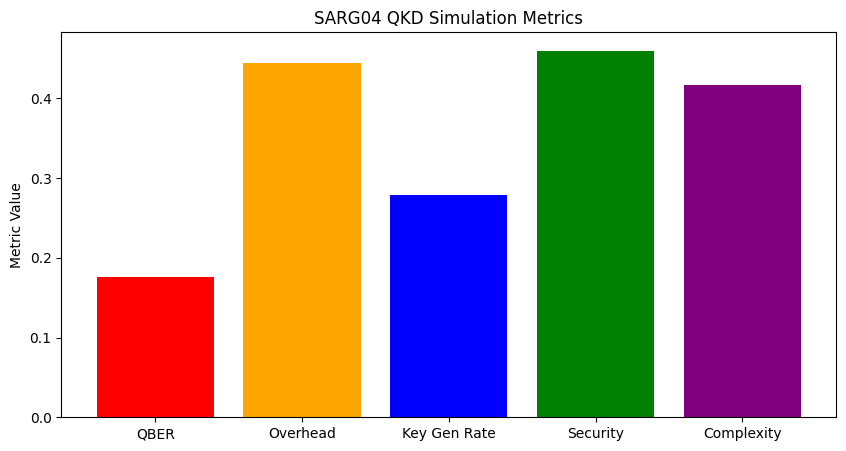

IoT Network Size: 5 devices
Data Bits Used: 10 bits
Success Rate: 0.17 (0.0 - 5.0 scale)

Metric Averages:
QBER: 0.18
Overhead: 0.44
Key Gen Rate: 0.28
Security: 0.46
Complexity: 0.42


In [ ]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

# Define IoT network parameters
NUM_DEVICES = 5  # Small home IoT network
DATA_BITS = 10  # 10-bit data transmission

# Simulated Metrics
QBER = np.random.uniform(0, 0.5, NUM_DEVICES)  # Quantum Bit Error Rate
OVERHEAD = np.random.uniform(0, 1, NUM_DEVICES)  # Communication overhead
KEY_GEN_RATE = np.random.uniform(0, 1, NUM_DEVICES)  # Key generation rate
SECURITY = np.random.uniform(0, 1, NUM_DEVICES)  # Security level
IMPLEMENTATION_COMPLEXITY = np.random.uniform(0, 1, NUM_DEVICES)  # Complexity factor

# Define Success Rate Formula (hypothetical model)
SUCCESS_RATE = 5.0 * (1 - QBER) * (KEY_GEN_RATE) * (SECURITY) / (OVERHEAD + IMPLEMENTATION_COMPLEXITY + 1)

# Normalize Success Rate to fit within 0.0 - 5.0 range
SUCCESS_RATE = np.clip(SUCCESS_RATE, 0.0, 5.0)

# Plot the results
metrics = ["QBER", "Overhead", "Key Gen Rate", "Security", "Complexity"]
avg_metrics = [np.mean(QBER), np.mean(OVERHEAD), np.mean(KEY_GEN_RATE), np.mean(SECURITY), np.mean(IMPLEMENTATION_COMPLEXITY)]

plt.figure(figsize=(10, 5))
plt.bar(metrics, avg_metrics, color=['red', 'orange', 'blue', 'green', 'purple'])
plt.ylabel("Metric Value")
plt.title("SARG04 QKD Simulation Metrics")
plt.show()

# Print summary
def print_summary():
    print(f"IoT Network Size: {NUM_DEVICES} devices")
    print(f"Data Bits Used: {DATA_BITS} bits")
    print(f"Success Rate: {SUCCESS_RATE.mean():.2f} (0.0 - 5.0 scale)")
    print("\nMetric Averages:")
    for metric, value in zip(metrics, avg_metrics):
        print(f"{metric}: {value:.2f}")

print_summary()

